In [1]:
%pip install matplotlib seaborn pandas numpy opencv-python pillow scikit-learn nltk beautifulsoup4

  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---------------------------------------- 0/2 [matplotlib]
   ---

In [12]:
# Installation des librairies manquantes (si nécessaire)
!pip install opencv-python pillow nltk scikit-learn matplotlib seaborn pandas numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# --- CORRECTION DES CHEMINS (Cellule 1) ---

# On utilise l'adresse exacte de votre dossier projet
BASE_DIR = r"C:\Users\amisf\Desktop\datascientest_projet"

# On reconstruit les chemins à partir de là
PATH_RAW = os.path.join(BASE_DIR, "data", "raw")
PATH_PROCESSED = os.path.join(BASE_DIR, "data", "processed")
PATH_IMAGES = os.path.join(PATH_RAW, "images", "images", "image_train")
# Vérification immédiate
if os.path.exists(PATH_RAW):
    print(f"✅ Dossier Data trouvé : {PATH_RAW}")
else:
    print(f"❌ Dossier Data INTROUVABLE au chemin : {PATH_RAW}")

os.makedirs(PATH_PROCESSED, exist_ok=True)

✅ Dossier Data trouvé : C:\Users\amisf\Desktop\datascientest_projet\data\raw


In [14]:
# --- STRATÉGIE DE PRE-PROCESSING (Basée sur Feature_Scaling.pdf) ---

def select_scaler(data_type, distribution="normal", outliers=False):
    """
    Sélectionne le scaler approprié selon la Cheat Sheet.
    """
    if data_type == 'image':
        # Règle PDF : "Deep Learning (CNN) -> Il faut absolument procéder au Feature Scaling"
        print("Stratégie Image : Normalisation (Pixel scaling 0-1) pour CNN.")
        return "normalization_255"
    
    elif data_type == 'text/tabular':
        # Règle PDF : "Algorithme de distance/gradient ? Oui -> Normalisation/Standardisation"
        if outliers:
            # Règle PDF : "Sensible aux valeurs aberrantes ? -> RobustScaler"
            print("Stratégie Tabulaire : RobustScaler (Présence d'outliers détectée).")
            return RobustScaler()
        else:
            # Règle PDF : "StandardScaler (Moyenne 0, Ecart-type 1)"
            print("Stratégie Tabulaire : StandardScaler (Distribution standard).")
            return StandardScaler()

# Application de la stratégie aux données Rakuten
print("--- Définition des stratégies ---")
STRATEGIE_IMG = select_scaler('image')
STRATEGIE_TXT = select_scaler('text/tabular', outliers=False)

--- Définition des stratégies ---
Stratégie Image : Normalisation (Pixel scaling 0-1) pour CNN.
Stratégie Tabulaire : StandardScaler (Distribution standard).


In [15]:
def preprocess_image(image_path, target_size=(224, 224), normalize=True):
    """
    Pipeline complet pour une image : Smart Crop -> Resize -> Normalisation
    """
    try:
        # 1. Chargement
        img = cv2.imread(image_path)
        if img is None: return None
        
        # 2. Smart Crop (Détourage)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV) # Seuil blanc
        coords = cv2.findNonZero(thresh)
        
        if coords is not None:
            x, y, w, h = cv2.boundingRect(coords)
            if w > 10 and h > 10: # Sécurité bruit
                img = img[y:y+h, x:x+w]

        # 3. Padding (Mise au carré) & Resize
        h, w = img.shape[:2]
        dim_max = max(w, h)
        top, bottom = (dim_max - h) // 2, dim_max - h - (dim_max - h) // 2
        left, right = (dim_max - w) // 2, dim_max - w - (dim_max - w) // 2
        
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        
        # Conversion couleur
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 4. Feature Scaling (Règle PDF)
        if normalize:
            img = img.astype('float32') / 255.0
            
        return img

    except Exception as e:
        print(f"Erreur : {e}")
        return None

print("Fonction de pré-traitement image définie.")

Fonction de pré-traitement image définie.


In [16]:
# --- DIAGNOSTIC CHEMIN IMAGES ---
import os

print(f"1. Chemin actuel configuré : {PATH_IMAGES}")

if os.path.exists(PATH_IMAGES):
    print("   -> Le dossier existe.")
    fichiers = os.listdir(PATH_IMAGES)
    print(f"   -> Il contient {len(fichiers)} fichiers.")
    print(f"   -> 5 premiers : {fichiers[:5]}")
else:
    print("   -> ❌ Le dossier n'existe pas.")
    
    # On regarde dans le dossier parent (data/raw)
    print(f"\n2. Contenu de {PATH_RAW} :")
    try:
        print(os.listdir(PATH_RAW))
        
        # On regarde dans data/raw/images s'il existe
        sub_path = os.path.join(PATH_RAW, "images")
        if os.path.exists(sub_path):
            print(f"\n3. Contenu de {sub_path} :")
            print(os.listdir(sub_path))
    except Exception as e:
        print(f"Erreur d'accès : {e}")

1. Chemin actuel configuré : C:\Users\amisf\Desktop\datascientest_projet\data\raw\images\images\image_train
   -> Le dossier existe.
   -> Il contient 84916 fichiers.
   -> 5 premiers : ['image_1000076039_product_580161.jpg', 'image_1000089455_product_348990858.jpg', 'image_1000092894_product_353108104.jpg', 'image_1000093804_product_343306951.jpg', 'image_1000095646_product_344209267.jpg']


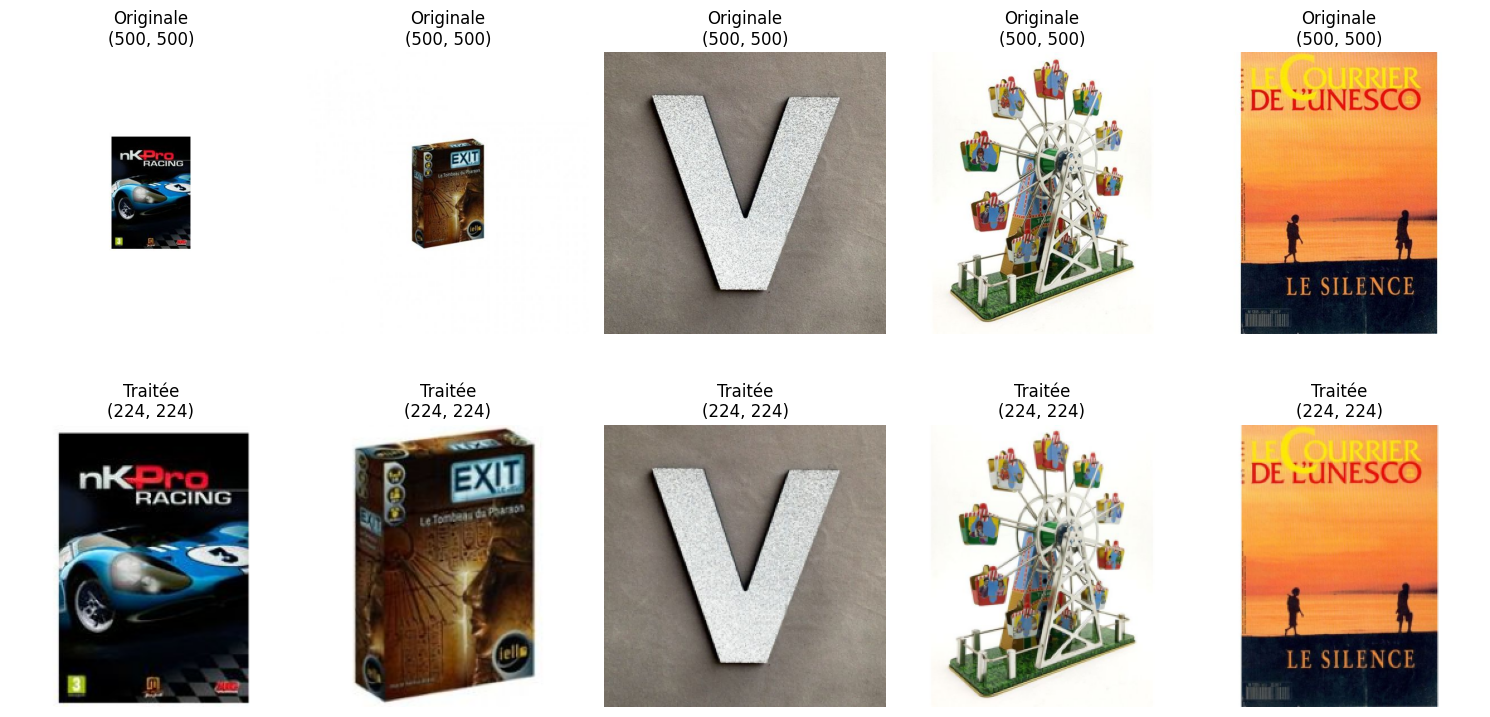

In [19]:
# --- CELLULE DE DIAGNOSTIC ET TEST VISUEL (AUTONOME) ---
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image  # C'est l'import qui manquait

# Configuration des chemins (en dur pour être sûr)
BASE_DIR = r"C:\Users\amisf\Desktop\datascientest_projet"
PATH_RAW = os.path.join(BASE_DIR, "data", "raw")

# 1. Fonction de recherche de fichier (Deep Search)
def find_image_file(image_id, product_id, search_path):
    filename = f"image_{image_id}_product_{product_id}.jpg"
    # On parcourt récursivement tous les dossiers
    for root, dirs, files in os.walk(search_path):
        if filename in files:
            return os.path.join(root, filename)
    return None

# 2. Chargement d'un échantillon (si df n'existe pas)
if 'df' not in locals():
    print("Chargement partiel du dataset pour le test...")
    df_x = pd.read_csv(os.path.join(PATH_RAW, "X_train_update.csv"), index_col=0)
    df_y = pd.read_csv(os.path.join(PATH_RAW, "Y_train_CVw08PX.csv"), index_col=0)
    df = pd.merge(df_x, df_y, left_index=True, right_index=True)

# 3. Test sur 5 exemples
exemples = df.sample(5, random_state=42)

plt.figure(figsize=(15, 8))

for i, (idx, row) in enumerate(exemples.iterrows()):
    # Recherche du chemin réel
    real_path = find_image_file(row['imageid'], row['productid'], PATH_RAW)
    
    # 1. Image Originale
    plt.subplot(2, 5, i+1)
    if real_path:
        try:
            img_orig = Image.open(real_path)
            plt.imshow(img_orig)
            plt.title(f"Originale\n{img_orig.size}")
            plt.axis('off')
            
            # 2. Image Traitée (Smart Crop)
            plt.subplot(2, 5, i+6)
            # On appelle votre fonction preprocess définie plus haut
            # Note: Si preprocess_image n'est pas définie, relancez la Cellule 3
            img_processed = preprocess_image(real_path, normalize=False)
            
            if img_processed is not None:
                plt.imshow(img_processed)
                plt.title(f"Traitée\n{img_processed.shape[:2]}")
                plt.axis('off')
        except Exception as e:
            print(f"Erreur lecture: {e}")
    else:
        plt.text(0.5, 0.5, "INTROUVABLE", ha='center')
        plt.axis('off')
        print(f"❌ Image introuvable : image_{row['imageid']}_product_{row['productid']}.jpg")

plt.tight_layout()
plt.show()

In [21]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amisf\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amisf\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\amisf\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [22]:
# --- FONCTION DE PRÉ-TRAITEMENT TEXTE (NLP) ---

import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# Chargement des stop words (mots vides) une seule fois pour gagner du temps
# On prend Français + Anglais + Allemand car Rakuten est international
stop_words = set(stopwords.words('french') + stopwords.words('english') + stopwords.words('german'))

def clean_text(text):
    """
    1. Gestion des NaN.
    2. Suppression HTML.
    3. Minuscules & Alphanumérique.
    4. Suppression des Stop Words.
    """
    # 1. Gestion des valeurs manquantes (NaN) -> On remplace par une chaine vide
    if pd.isna(text):
        return ""
    
    # 2. Suppression des balises HTML (ex: <div>, <br>)
    text = BeautifulSoup(str(text), "html.parser").get_text()
    
    # 3. Passage en minuscules et conservation uniquement des lettres (pas de chiffres/ponct)
    text = re.sub(r"[^a-zA-Zà-üÀ-Ü]", " ", text.lower())
    
    # 4. Tokenization (découpage) et filtrage des Stop Words
    words = text.split()
    words_cleaned = [w for w in words if w not in stop_words and len(w) > 1]
    
    # On rejoint les mots pour refaire une phrase propre
    return " ".join(words_cleaned)

print("Fonction de nettoyage texte (NLP) définie.")

Fonction de nettoyage texte (NLP) définie.


In [23]:
# Test sur 3 descriptions aléatoires
exemples_text = df['description'].dropna().sample(3, random_state=42)

print("--- TEST NETTOYAGE TEXTE (AVANT / APRÈS) ---\n")
for idx, txt in exemples_text.items():
    print(f"[ORIGINAL] : {txt[:100]}...")
    print(f"[NETTOYÉ ] : {clean_text(txt)[:100]}...")
    print("-" * 50)

--- TEST NETTOYAGE TEXTE (AVANT / APRÈS) ---

[ORIGINAL] : chaise chilienne deco toile de jute ...
[NETTOYÉ ] : chaise chilienne deco toile jute...
--------------------------------------------------
[ORIGINAL] : <p>Le matelas en mousse de m&eacute;moire <strong>2 Strati Monozona 14 cm + 3 cm Memory Foam</strong...
[NETTOYÉ ] : matelas mousse mémoire strati monozona cm cm memory foam matelas excellent qualité hauteur cm compos...
--------------------------------------------------
[ORIGINAL] : Géométrique Enfants Baby Puzzle en bois Anime 3D en bois apprentissage jouet éducatif Feature: tout ...
[NETTOYÉ ] : géométrique enfants baby puzzle bois anime bois apprentissage jouet éducatif feature tout neuf haute...
--------------------------------------------------


In [24]:
# nettoyage pour ensemble du texte

# combler les valeurs qui manque
mask_null = df['description'].isnull()
df.loc[mask_null, 'description'] = df.loc[mask_null, 'designation']
print(f"- {mask_null.sum()} descriptions manquantes remplies par le titre.")

# pour nettoyer
df['description_cleaned'] = df['description'].astype(str).apply(clean_text)

#  pour Sauvegarde
output_csv = os.path.join(PATH_PROCESSED, "X_train_cleaned_text.csv")
df.to_csv(output_csv)

print(f"✅ Traitement texte terminé. Fichier sauvegardé : {output_csv}")
display(df[['designation', 'description', 'description_cleaned']].head())

- 29800 descriptions manquantes remplies par le titre.


C:\Users\amisf\AppData\Local\Temp\ipykernel_19576\690580507.py:23: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  text = BeautifulSoup(str(text), "html.parser").get_text()


✅ Traitement texte terminé. Fichier sauvegardé : C:\Users\amisf\Desktop\datascientest_projet\data\processed\X_train_cleaned_text.csv


,designation,description,description_cleaned
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,Olivia: Personalisiertes Notizbuch / 150 Seite...,olivia personalisiertes notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,journal arts art marche salon art asiatique pa...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,pilot style touch pen marque speedlink stylet ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,Peluche Donald - Europe - Disneyland 2000 (Mar...,peluche donald europe disneyland marionnette d...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,luc idées grandeur veut organiser jeu guerre b...
